In [6]:
import pandas as pd
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy.stats as sts
import ast
from scipy.interpolate import interp1d
from collections import OrderedDict
from matplotlib.transforms import blended_transform_factory
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import os
plt.close('all')
plt.style.use('default')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

LEGEND_FONT_SIZE = 30
AXIS_FONT_SIZE = 35
TICKS_FONT_SIZE = 26
LINE_WIDTH = 3.0

figs = []
%matplotlib inline
def running_mean(x, N):
    divider = np.convolve(np.ones_like(x), np.ones((N,)), mode='same')
    return np.convolve(x, np.ones((N,)), mode='same') / divider

base_dir = '../logs/highway/trained/'

In [7]:
linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),

     ('loosely dashdashdotted', (0, (3, 10, 3, 10, 1, 10))),
     ('dashdashdotted',         (0, (3, 5, 3, 5, 1, 5))),
     ('densely dashdashdotted', (0, (3, 1, 3, 1, 1, 1)))])

ls = [linestyles['solid'], linestyles['dashed'], linestyles['dotted'], 
      linestyles['dashdotted'], linestyles['dashdotdotted'], linestyles['dashdashdotted'],
      linestyles['densely dashed'], linestyles['densely dotted']]

colors = ['r', 'b', 'g','orange','c', 'k','purple', 'y']

In [10]:
def show_kpi(kpi,settings,episodes_per_batch,rows_to_show_array, xs_best, N=1, setting_to_label=None):
    kpi_label=kpi.replace("_","-")
    conf = 0.95
    max_alpha=1
    horizon=400
    delta_alpha=0.05
    limits=[(-10000,80000),(-1,17.5),(0,420),(0,50),(0,110000),(-200,10)]
    eval_episodes=24
    crash_punishments=[]
    num_iters=20
    
    if settings is None:
        settings=["rew_60_1.6667_1_10","rew_60_3.3333_1_20"]
    results=list(range(len(settings)))
    std_results=list(range(len(settings)))
    min_rows=5000
    if rows_to_show_array is None:
        rows_to_show_array=[280]
    for i,setting in enumerate(settings):
        rows_to_show = rows_to_show_array[i]
        results[i]=[]
        paths = glob.glob(base_dir +setting+"/eval_KPI_episodes-*.csv")
        for p in paths:
            data=np.array(pd.read_csv(p)[kpi])
            if(data.shape[0]<min_rows):
                min_rows=data.shape[0]
            results[i].append(data[:rows_to_show])
    
    max_data=min_rows-min_rows%eval_episodes
    legend_labels = []
    legend_colors = []
    fig, ax = plt.subplots(2, 2, figsize=(15, 12))
    for i,arrays in enumerate(results):
        row = i // 2
        colum = i % 2
        n_runs=len(arrays)
        red_arr=list(range(n_runs))
        red_arr_std=list(range(n_runs))
        for j,ar in enumerate(arrays):
            red_arr[j]=np.mean(np.split(ar,ar.shape[0]/eval_episodes),axis=1)
            red_arr_std[j]=np.std(np.split(ar,ar.shape[0]/eval_episodes),axis=1)
            
        std_results[i]=np.std(np.stack(red_arr),axis=0)
        results[i]=np.mean(np.stack(red_arr),axis=0)
        
        col = colors[i]
        ys=results[i]
        ys = running_mean(ys, N)
        if n_runs > 1:
            std_ys=std_results[i]
        else:
            std_ys=red_arr_std[0]
        if setting_to_label is None:
            label=settings[i].replace('_',"-")
        else:
            label = setting_to_label[settings[i]]
        steps_per_epoch=episodes_per_batch[i]*horizon*num_iters
        xs=np.array([i for i in range(len(ys))])*steps_per_epoch
        if kpi_label=='sum-reward':
            xs_best[i]=xs[np.argmax(ys)]
            kpi_label='Return'
        ax[row, colum].plot(xs,ys,label=label,color=col)
        ax[row, colum].set_title(label, fontdict={'fontsize':30})
        if n_runs > 1:
            ax[row, colum].fill_between(xs,ys-std_ys/np.sqrt(n_runs), ys+std_ys/np.sqrt(n_runs),color=col, alpha=0.2)
        if kpi_label in ['blocked-dangerous-manouvers', 'steps-free-right',] or i in [2,3]:
            ax[row, colum].set_xlabel('samples', fontsize=AXIS_FONT_SIZE)
        if i in [0, 2]:
            ax[row, colum].set_ylabel(kpi_label, fontsize=AXIS_FONT_SIZE)
        ax[row, colum].xaxis.offsetText.set_fontsize(TICKS_FONT_SIZE+2)
        ax[row, colum].yaxis.offsetText.set_fontsize(TICKS_FONT_SIZE+2)
        ax[row, colum].tick_params(labelsize=TICKS_FONT_SIZE)        
        legend_labels.append(label)
        legend_colors.append(col)
    if not os.path.exists('irl_graphs'):
        os.makedirs('irl_graphs')
    fig.savefig('irl_graphs/'+kpi_label + '.pdf',format='pdf')
    fig = plt.figure(figsize=(7, 0.2))
    patches = [
        mpatches.Patch(color=legend_colors[i], label=legend_labels[i], )
        for i in range(len(legend_colors))]
    patches = [ mlines.Line2D([], [], color=legend_colors[i],
                              label=legend_labels[i], linewidth=LINE_WIDTH)  for i in range(len(legend_labels)) ]

    lgd=fig.legend( patches, legend_labels, ncol=10, loc='center', frameon=False, fontsize=LEGEND_FONT_SIZE)
    fig.savefig('irl_graphs/legend.pdf',format='pdf',bbox_extra_artists=(lgd,), bbox_inches='tight',)
    return xs_best

# Plot the training curves of the trained agents (Figure 24)
## Prerequisite: Uses the data loaded in the repo (we cannot provide the simulator)

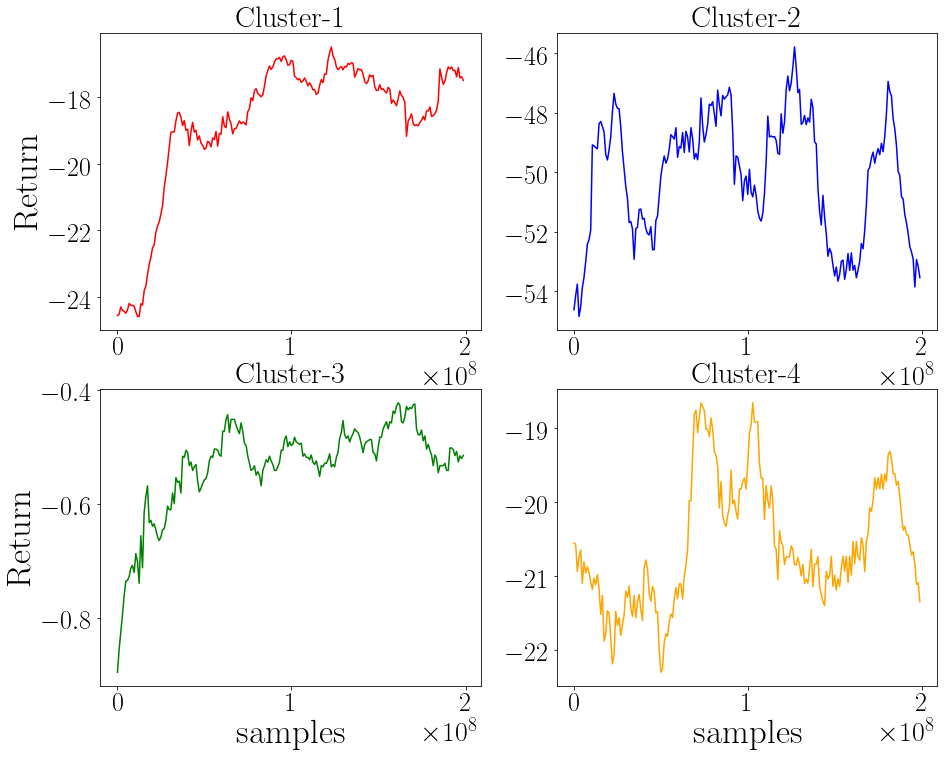

<Figure size 504x14.4 with 0 Axes>

In [11]:
kpis=['sum_reward']
settings=['Cluster_1','Cluster_2','Cluster_3','Cluster_4'] 
episodes_per_batch=[120,120,120,120]
rows_to_show=[4992,4992,4992,4992,4992]
xs_best = np.zeros(len(settings))
for kpi in kpis[0:]:
    show_kpi(kpi,settings,episodes_per_batch,rows_to_show, xs_best, N=20)

In [25]:
def show_kpi_together(kpi,settings,episodes_per_batch,rows_to_show_array, xs_best, N=1, setting_to_label=None):
    kpi_label=kpi.replace("_","-")
    conf = 0.95
    max_alpha=1
    horizon=400
    delta_alpha=0.05
    limits=[(-10000,80000),(-1,17.5),(0,420),(0,50),(0,110000),(-200,10)]
    eval_episodes=24
    crash_punishments=[]
    num_iters=20
    
    if settings is None:
        settings=["rew_60_1.6667_1_10","rew_60_3.3333_1_20"]
    results=list(range(len(settings)))
    std_results=list(range(len(settings)))
    min_rows=5000
    if rows_to_show_array is None:
        rows_to_show_array=[280]
    for i,setting in enumerate(settings):
        rows_to_show = rows_to_show_array[i]
        results[i]=[]
        paths = glob.glob(base_dir + setting + "/eval_KPI_episodes-*.csv")
        for p in paths:
            data=np.array(pd.read_csv(p)[kpi])
            if(data.shape[0]<min_rows):
                min_rows=data.shape[0]
            results[i].append(data[:rows_to_show])
    
    max_data=min_rows-min_rows%eval_episodes
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))
    for i,arrays in enumerate(results):
        n_runs=len(arrays)
        red_arr=list(range(n_runs))
        red_arr_std=list(range(n_runs))
        for j,ar in enumerate(arrays):
            red_arr[j]=np.mean(np.split(ar,ar.shape[0]/eval_episodes),axis=1)
            red_arr_std[j]=np.std(np.split(ar,ar.shape[0]/eval_episodes),axis=1)
            
        std_results[i]=np.std(np.stack(red_arr),axis=0)
        results[i]=np.mean(np.stack(red_arr),axis=0)
        
        col = colors[i]
        ys=results[i]
        ys = running_mean(ys, N)
        if n_runs > 1:
            std_ys=std_results[i]
        else:
            std_ys=red_arr_std[0]
        if setting_to_label is None:
            label=settings[i].replace('_',"-")
        else:
            label = setting_to_label[settings[i]]
        steps_per_epoch=episodes_per_batch[i]*horizon*num_iters
        xs=np.array([i for i in range(len(ys))])*steps_per_epoch
        if kpi_label=='sum-reward':
            xs_best[i]=xs[np.argmax(ys)]
            kpi_label='return'
        ax.plot(xs,ys,label=label,color=col)
        if n_runs > 1:
            ax.fill_between(xs,ys-std_ys/np.sqrt(n_runs), ys+std_ys/np.sqrt(n_runs),color=col, alpha=0.2)
        if kpi_label in ['blocked-dangerous-manouvers', 'steps-free-right',]:
            ax.set_xlabel('samples', fontsize=AXIS_FONT_SIZE)
        ax.set_ylabel(kpi_label, fontsize=AXIS_FONT_SIZE)
        ax.xaxis.offsetText.set_fontsize(TICKS_FONT_SIZE+2)
        ax.yaxis.offsetText.set_fontsize(TICKS_FONT_SIZE+2)
        ax.tick_params(labelsize=TICKS_FONT_SIZE)
    if not os.path.exists('irl_graphs'):
        os.makedirs('irl_graphs')
    
    fig.savefig('irl_graphs/'+kpi_label+'.pdf',format='pdf')
    return fig

# Plot the training curves of the trained agents for some KPIs of interest described in https://www.sciencedirect.com/science/article/abs/pii/S0921889020304085
## Prerequisite: Uses the data loaded in the repo (we cannot provide the simulator)

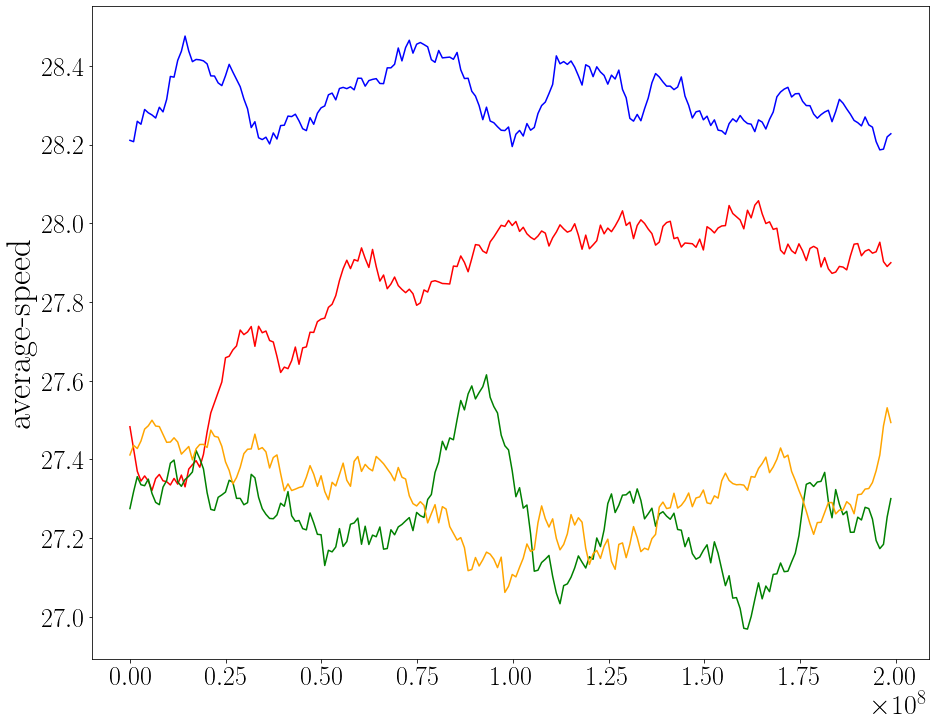

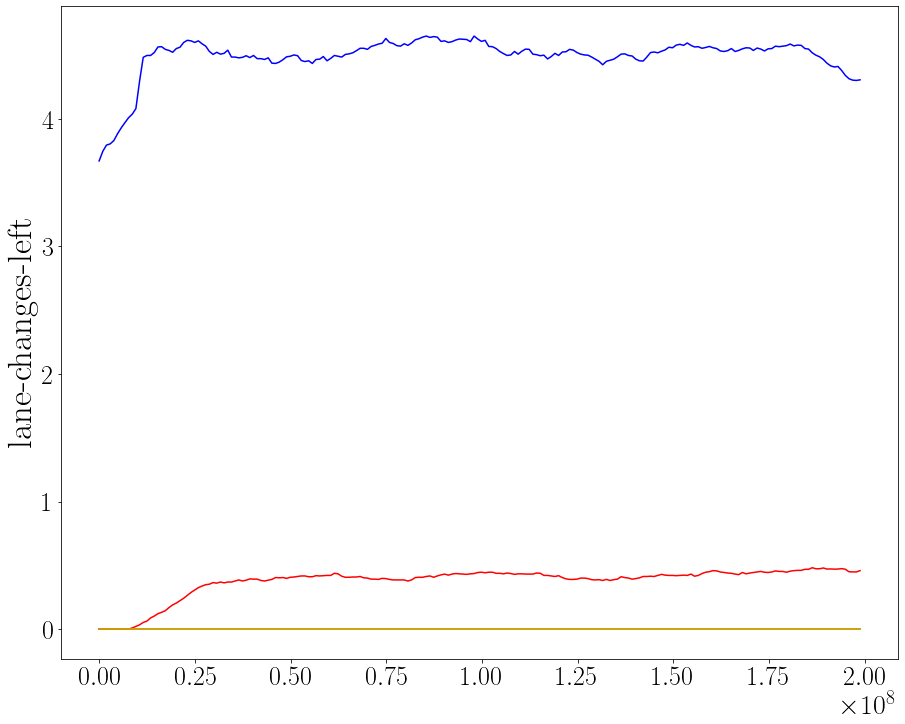

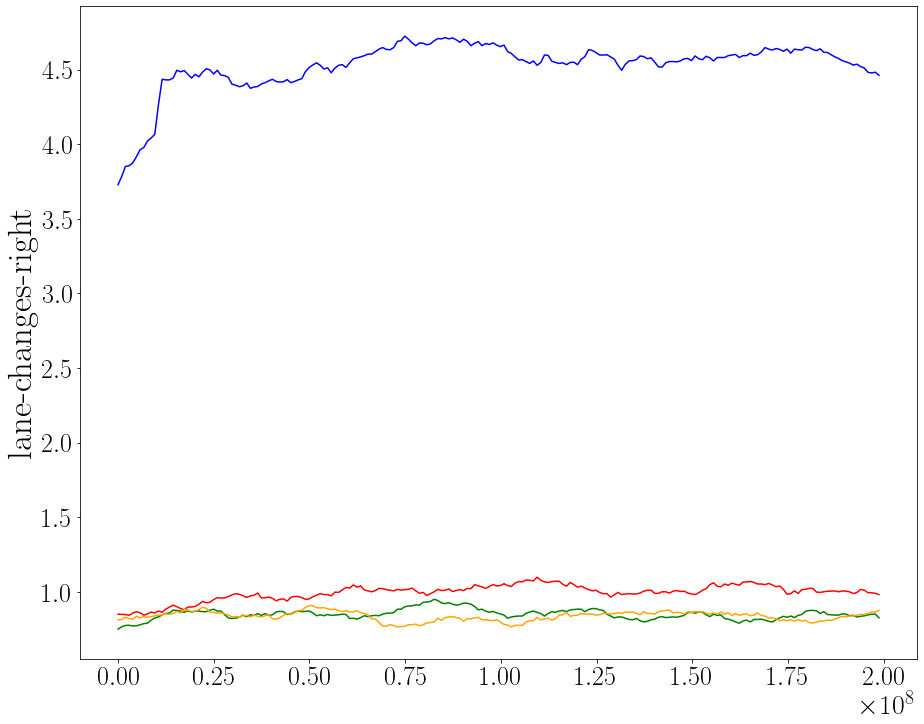

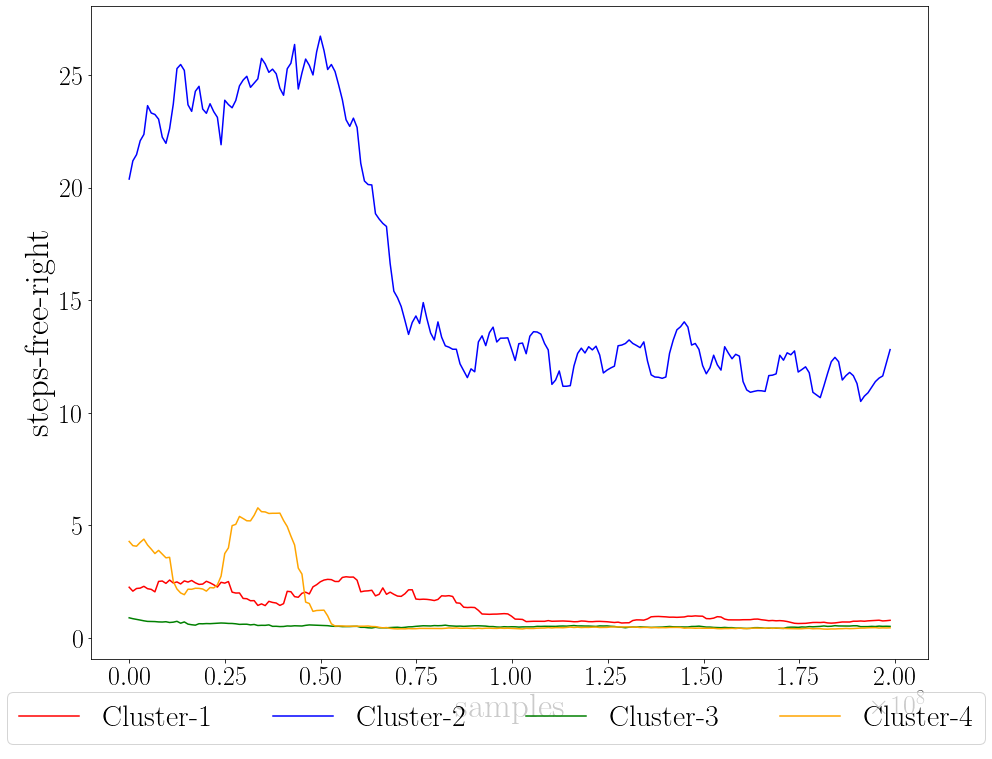

In [26]:
kpis=['sum_reward', 'average_speed', 'lane_changes_left', 'lane_changes_right', 'steps_free_right', ]

settings=['Cluster_1','Cluster_2','Cluster_3','Cluster_4'] 
episodes_per_batch=[120,120,120,120]
rows_to_show=[4992,4992,4992,4992,4992] 
xs_best = np.zeros(len(settings))
for kpi in kpis[1:]:
    fig = show_kpi_together(kpi,settings,episodes_per_batch,rows_to_show, xs_best, N=20,)
fig.legend(ncol=10, loc='lower center',  fontsize=LEGEND_FONT_SIZE)